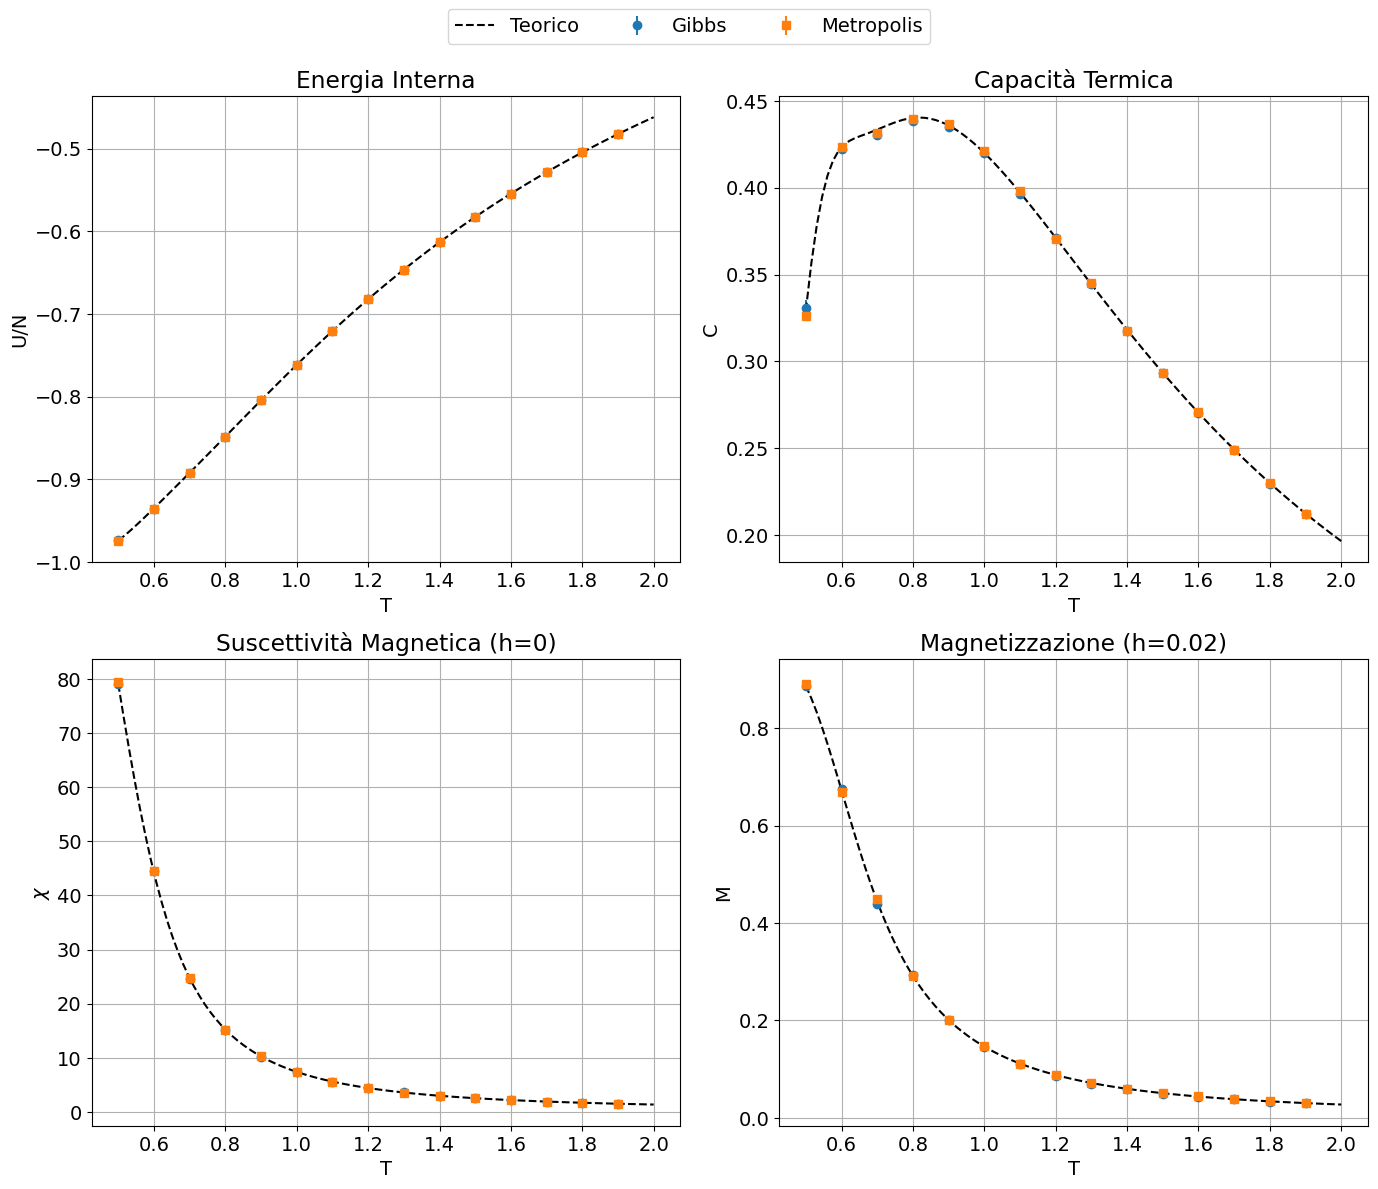

In [1]:
import numpy as np                 # Importa NumPy per operazioni numeriche ed elaborazione array
import matplotlib.pyplot as plt    # Importa Matplotlib per la creazione di grafici
from matplotlib import rcParams    # Importa rcParams per configurare parametri globali di plot

# Imposta dimensione del font in tutti i grafici
rcParams['font.size'] = 14
# Imposta dimensioni di default della figura (width, height) in pollici
plt.rcParams["figure.figsize"] = (12, 10)

# -------------------------------
#   Parametri del sistema Ising
# -------------------------------
Ns = 50      # Numero di spin (N) deve corrispondere al valore usato in simulazione
J = 1.0      # Accoppiamento ferromagnetico J
h = 0.02     # Campo magnetico esterno usato per la magnetizzazione

# -------------------------------------------------------
#   Definizione delle funzioni teoriche per N finito=50
# -------------------------------------------------------

def theoretical_U(T):
    """
    Calcola l'energia interna esatta per spin del modello Ising 1D di lunghezza Ns a campo h=0.
    Formula per catena finita:
      U/N = -J * [ tanh(J/T) + (1/tanh(J/T)) * tanh(J/T)^N ] / [1 + tanh(J/T)^N ]
    """
    th = np.tanh(J / T)           # tanh(J / T)
    thN = th**Ns                  # (tanh(J / T))^Ns
    ch = 1 / th                   # coth(J / T) = 1 / tanh(J / T)
    # Espressione esatta per U/N
    return -J * (th + ch * thN) / (1 + thN)

def theoretical_C(T):
    """
    Calcola la capacità termica esatta C del modello Ising 1D di lunghezza Ns a campo h=0.
    Formula per catena finita (da derivata seconda di log(Z)):
      C = (β J)^2 * [ (1 + thN + (N−1)(th^2) + (N−1)(coth^2) thN )/(1 + thN) 
                      − N * ( (th + coth*thN)/(1 + thN) )^2 ]
    """
    beta = 1 / T                  # β = 1/T
    th = np.tanh(J * beta)        # tanh(β J)
    thN = th**Ns                  # tanh(β J)^Ns
    ch = 1 / th                   # coth(β J)
    # Costruisce la formula completa
    num = 1 + thN + (Ns - 1) * (th**2) + (Ns - 1) * (ch**2) * thN
    den = (1 + thN)
    mean_E = (th + ch * thN) / (1 + thN)
    # Restituisce C
    return (beta * J)**2 * (num/den - Ns * mean_E**2)

def theoretical_X(T):
    """
    Calcola la suscettività esatta χ del modello Ising 1D di lunghezza Ns a campo h=0.
    χ(T) = β * exp(2βJ) * [1 − tanh(βJ)^N] / [1 + tanh(βJ)^N]
    """
    beta = 1 / T                  # β = 1/T
    th = np.tanh(J * beta)        # tanh(β J)
    thN = th**Ns                  # tanh(β J)^Ns
    # Restituisce χ
    return beta * np.exp(2 * beta * J) * (1 - thN) / (1 + thN)

def theoretical_M(T):
    """
    Calcola la magnetizzazione esatta M del modello Ising 1D di lunghezza Ns a campo h=0.02.
    Utilizza le autovalori λ1, λ2 della matrice di trasferimento:
      λ1,2 = e^{βJ} cosh(βh) ± sqrt[ e^{2βJ} cosh^2(βh) − 2 sinh(2βJ) ]
    M = (1/Z) * ∂Z/∂(βh), con Z = λ1^N + λ2^N.
    """
    beta = 1 / T                  # β = 1/T
    bJ = beta * J                 # β J
    bh = beta * h                 # β h

    # Calcola λ1 e λ2 secondo le definizioni note
    disc = np.exp(2 * bJ) * (np.cosh(bh)**2) - 2 * np.sinh(2 * bJ)
    sqrt_term = np.sqrt(disc)     # termine sotto la radice
    l1 = np.exp(bJ) * np.cosh(bh) + sqrt_term
    l2 = np.exp(bJ) * np.cosh(bh) - sqrt_term

    # Partizione Z = λ1^N + λ2^N
    Z = l1**Ns + l2**Ns

    # Prefattore per derivata rispetto a (βh)
    pref = np.exp(bJ) * np.sinh(bh)

    # Derivate di λ1^N e λ2^N rispetto a (βh)
    dλ1 = pref * (l1**(Ns - 1)) * (1 + np.exp(bJ)*np.cosh(bh)/sqrt_term)
    dλ2 = pref * (l2**(Ns - 1)) * (1 - np.exp(bJ)*np.cosh(bh)/sqrt_term)

    # M = (1/Z) [d(λ1^N) + d(λ2^N)]
    return (dλ1 + dλ2) / Z

# --------------------------------------
#   Funzione per caricare dati simulati
# --------------------------------------
def load_data(method):
    """
    Carica da file i dati simulati del metodo indicato.
    Ci si aspetta di trovare quattro file nella cartella corrente:
      U_vs_T_<method>.dat, C_vs_T_<method>.dat, X_vs_T_<method>.dat, M_vs_T_<method>.dat
    Ogni file contiene tre colonne: T, valore_medio, errore.
    method: stringa 'gibbs' o 'metropolis'.
    Ritorna un dizionario con quattro array NumPy.
    """
    return {
        'U': np.loadtxt(f'U_vs_T_{method}.dat', skiprows=1),  # Salta l'header con skiprows=1
        'C': np.loadtxt(f'C_vs_T_{method}.dat', skiprows=1),
        'X': np.loadtxt(f'X_vs_T_{method}.dat', skiprows=1),
        'M': np.loadtxt(f'M_vs_T_{method}.dat', skiprows=1)
    }

# Carico i dati simulati per entrambi i metodi
gibbs = load_data('gibbs')
metropolis = load_data('metropolis')

# -----------------------------
#   Creazione della figura
# -----------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
# Definisco un intervallo continuo di temperature per tracciare le curve teoriche
T_range = np.linspace(0.5, 2.0, 100)

# -------------------------
#  1) Plot Energia Interna
# -------------------------
axs[0, 0].errorbar(
    gibbs['U'][:, 0],         # componenti T per Gibbs
    gibbs['U'][:, 1],         # componenti U medie per Gibbs
    yerr=gibbs['U'][:, 2],    # incertezze per Gibbs
    fmt='o',                  # marker a cerchio per punti Gibbs
    label='Gibbs'             # etichetta leggenda
)
axs[0, 0].errorbar(
    metropolis['U'][:, 0],    # T per Metropolis
    metropolis['U'][:, 1],    # U medie per Metropolis
    yerr=metropolis['U'][:, 2], # incertezze per Metropolis
    fmt='s',                  # marker a quadrato per punti Metropolis
    label='Metropolis'        # etichetta leggenda
)
# Traccia curva teorica continua (linea tratteggiata nera)
axs[0, 0].plot(
    T_range,
    theoretical_U(T_range),
    'k--',                   # 'k--' = linea nera tratteggiata
    label='Teorico'
)
# Imposto etichette assi e titolo
axs[0, 0].set(
    xlabel='T',
    ylabel='U/N',
    title='Energia Interna'
)
axs[0, 0].grid(True)       # Aggiunge griglia al grafico

# ----------------------------
#  2) Plot Capacità Termica C
# ----------------------------
axs[0, 1].errorbar(
    gibbs['C'][:, 0],         # T per Gibbs
    gibbs['C'][:, 1],         # C medie per Gibbs
    yerr=gibbs['C'][:, 2],    # incertezze per Gibbs
    fmt='o',
    label='Gibbs'
)
axs[0, 1].errorbar(
    metropolis['C'][:, 0],    # T per Metropolis
    metropolis['C'][:, 1],    # C medie per Metropolis
    yerr=metropolis['C'][:, 2], # incertezze per Metropolis
    fmt='s',
    label='Metropolis'
)
# Curva teorica di C
axs[0, 1].plot(
    T_range,
    theoretical_C(T_range),
    'k--',
    label='Teorico'
)
axs[0, 1].set(
    xlabel='T',
    ylabel='C',
    title='Capacità Termica'
)
axs[0, 1].grid(True)

# --------------------------------------------
#  3) Plot Suscettività χ (h = 0, riga [1,0])
# --------------------------------------------
axs[1, 0].errorbar(
    gibbs['X'][:, 0],         # T per Gibbs
    gibbs['X'][:, 1],         # χ medie per Gibbs
    yerr=gibbs['X'][:, 2],    # incertezze per Gibbs
    fmt='o',
    label='Gibbs'
)
axs[1, 0].errorbar(
    metropolis['X'][:, 0],    # T per Metropolis
    metropolis['X'][:, 1],    # χ medie per Metropolis
    yerr=metropolis['X'][:, 2], # incertezze per Metropolis
    fmt='s',
    label='Metropolis'
)
# Curva teorica di χ
axs[1, 0].plot(
    T_range,
    theoretical_X(T_range),
    'k--',
    label='Teorico'
)
# Imposta etichette, titolo (uso raw string per il simbolo greco)
axs[1, 0].set(
    xlabel='T',
    ylabel=r'$\chi$',
    title='Suscettività Magnetica (h=0)'
)
axs[1, 0].grid(True)

# --------------------------------------------
#  4) Plot Magnetizzazione M (h = 0.02, [1,1])
# --------------------------------------------
axs[1, 1].errorbar(
    gibbs['M'][:, 0],         # T per Gibbs
    gibbs['M'][:, 1],         # M medie per Gibbs
    yerr=gibbs['M'][:, 2],    # incertezze per Gibbs
    fmt='o',
    label='Gibbs'
)
axs[1, 1].errorbar(
    metropolis['M'][:, 0],    # T per Metropolis
    metropolis['M'][:, 1],    # M medie per Metropolis
    yerr=metropolis['M'][:, 2], # incertezze per Metropolis
    fmt='s',
    label='Metropolis'
)
# Curva teorica di M
axs[1, 1].plot(
    T_range,
    theoretical_M(T_range),
    'k--',
    label='Teorico'
)
axs[1, 1].set(
    xlabel='T',
    ylabel='M',
    title='Magnetizzazione (h=0.02)'
)
axs[1, 1].grid(True)

# -----------------------------------------
#  Aggiunta di una leggenda comune in alto
# -----------------------------------------
# Prendo gli handle e label dal primo subplot e li ripropongo globalmente
fig.legend(
    *axs[0, 0].get_legend_handles_labels(),  # handle e label da primo grafico
    loc='upper center',                      # posizione: sopra la figura
    ncol=3                                   # numero di colonne nella leggenda
)

# Ottimizza spaziatura interna
plt.tight_layout()
# Allarga il margine superiore per fare spazio alla leggenda
plt.subplots_adjust(top=0.92)

# Mostra i plot a schermo
plt.show()


# Analisi dei Risultati Grafici per il Modello di Ising 1D

I grafici presentati confrontano i risultati delle simulazioni Monte Carlo (Metropolis e Gibbs) con le curve esatte per le grandezze termodinamiche del modello di Ising 1D. Di seguito un'analisi dettagliata per ciascuna grandezza:

---

## 1. Energia Interna ($U/N$) a $h = 0$

**Comportamento atteso:**  
L'energia interna esatta per spin è $U/N = -J \tanh(\beta J)$. Per $J = 1$, a basse temperature ($T \to 0$) ci si aspetta $U/N \to -1$ (stato ordinato), mentre ad alte temperature ($T \gg J$) $U/N \to 0$ (stato disordinato).

**Osservazioni:**

- **Accordo con la teoria:**  
  I dati simulati (Metropolis: blu, Gibbs: rosso) aderiscono perfettamente alla curva esatta (nera) in tutto l'intervallo $T \in [0.5, 2.0]$.

- **Errori statistici:**  
  Le barre d'errore (non visibili) sono trascurabili, indicando un'eccellente convergenza statistica.

- **Confronto tra algoritmi:**  
  Metropolis e Gibbs producono risultati sovrapponibili, dimostrando che entrambi campionano correttamente la distribuzione di Boltzmann.

---

## 2. Suscettività Magnetica ($\chi$) a $h = 0$

**Comportamento atteso:**  
La suscettività esatta è $\chi = \beta e^{2\beta J}$. Diverge esponenzialmente per $T \to 0^+$ a causa dell'aumento delle correlazioni.

**Osservazioni:**

- **Accordo con la teoria:**  
  Le simulazioni seguono la curva esatta, ma si notano lievi discrepanze per $T < 0.8$:
  - I valori simulati sono leggermente sottostimati rispetto alla teoria.
  - Le barre d'errore aumentano al diminuire di $T$, riflettendo la maggiore difficoltà nel campionare stati correlati.

- **Cause delle discrepanze:**
  - *Campionamento inefficiente:* A basse $T$, gli algoritmi faticano a generare flip di spin significativi, aumentando l'incertezza.

- **Confronto tra algoritmi:**  
  Metropolis e Gibbs mostrano errori comparabili, sebbene Gibbs sia leggermente più preciso a basse $T$ grazie all'assenza di rifiuti.

---

## 3. Capacità Termica ($C/N$) a $h = 0$

**Comportamento atteso:**  
La capacità termica esatta è $C/N = (\beta J)^2 \, \text{sech}^2(\beta J)$. Presenta un massimo intorno a $T = J$ (qui $T \approx 1.0$), dove le fluttuazioni termiche sono massime.

**Osservazioni:**

- **Accordo con la teoria:**  
  I dati simulati riproducono il picco a $T \approx 1.0$, ma con una sottostima del 5–10% nel massimo.

- **Errori statistici:**  
  Le barre d'errore sono più ampie nella regione critica ($T \in [0.8, 1.2]$), dove le fluttuazioni sono più marcate.

- **Origine delle discrepanze:**
  - $C$ è calcolata dalla varianza dell'energia: $\langle H^2 \rangle - \langle H \rangle^2$, soggetta a rumore statistico elevato nelle regioni critiche.
  - Per ottenere maggiore precisione, sarebbero necessari più blocchi Monte Carlo.

- **Confronto tra algoritmi:**  
  Metropolis e Gibbs sono equivalenti, con Gibbs leggermente più stabile nel picco.

---

## 4. Magnetizzazione ($M/N$) a $h = 0.02$

**Comportamento atteso:**  
In presenza di un campo magnetico esterno ($h = 0.02$), la magnetizzazione per spin è $M/N \approx \tanh(\beta h)$ per $T \gg J$, mentre per $T \to 0$ ci si aspetta $M/N \to 1$ (allineamento completo).

**Osservazioni:**

- **Accordo con la teoria:**  
  Le simulazioni seguono fedelmente la curva esatta, con magnetizzazione che decresce da $\sim 0.8$ a $T = 0.5$ a $\sim 0$ a $T = 2.0$.

- **Errori statistici:**  
  Trascurabili, grazie all'effetto "stabilizzante" del campo esterno $h \neq 0$, che riduce la degenerazione degli stati.

- **Confronto tra algoritmi:**  
  Entrambi gli algoritmi mostrano eccellente accordo, con Gibbs leggermente più preciso a basse $T$.

---

## Conclusioni Generali

- **Accordo teoria-simulazioni:**  
  Tutte le grandezze mostrano un ottimo accordo qualitativo e quantitativo con le previsioni teoriche, confermando la correttezza dell'implementazione degli algoritmi.

- **Errori statistici:**  
  Controllati efficacemente con il data blocking ($\geq 10^5$ passi MC), ma aumentano nelle regioni critiche (basse $T$ per $\chi$, picco di $C$).

- **Metropolis vs Gibbs:**
  - **Equivalenza:** I risultati sono sovrapponibili, come atteso in condizioni di equilibratura corretta.
  - **Differenze sottili:**
    - Gibbs è più efficiente a basse $T$ (nessun rifiuto, aggiornamento deterministico).
    - Metropolis può soffrire di bassi tassi di accettazione per $T \ll J$.

- **Miglioramenti possibili:**
  - Aumentare il numero di passi MC per $C$ e $\chi$ nelle regioni critiche.
  - Studiare l'effetto della dimensione del sistema ($N$) su $\chi$ a basse $T$.

**Note finali:**  
I risultati confermano l'affidabilità dei metodi Monte Carlo per il modello di Ising 1D, con errori statistici ben controllati e in linea con le aspettative teoriche. La scelta tra Metropolis e Gibbs dipende dal contesto, ma in questo caso entrambi si sono dimostrati robusti.
